#  Проект по построению модели прогнозирования заказов такси

## Введение

**Вводные данные проекта:**

**Заказчик:** компания «Чётенькое такси».

**Цель проекта:** построить модель прогнозирования количества заказов такси на следующий час для привлечения большего числа водителей в период пиковой нагрузки.

**Дополнительные условия заказчика:**
- значение метрики RMSE на тестовой выборке не больше 48.

**Данные для анализа и построения модели:** исторические данные о заказах такси в аэропортах.

**Этапы проекта:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные и подготовить их к обучению (создать дополнительные признаки).
3. Осуществить подбор параметров для лучших моделей и выбрать одну для тестирования.
4. Протестировать модель и сравнить результаты с целевым значением RMSE (не более 48).
5. Сделать выводы по результатам проекта.

## Загрузка и подготовка данных

In [1]:
# необходимые библиотеки
# для работы с данными (предобработка, исследовательский анализ)
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import time

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# для машинного обучения
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
import lightgbm as ltb

In [2]:
# константа
SEED = 12345

In [3]:
data = pd.read_csv('/datasets/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Посмотрим общую информацию о данных.

In [4]:
def info_all(data):
    '''функция оценивает общую информацию о данных'''
    print('-'*50)
    print('Общая информация о данных')
    temp = data.copy() 
    list_c = data.columns
    print(temp.info())
    for col_l in list_c:
        print('-'* 25)
        print(col_l, temp[col_l].sort_values().unique())
        print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')
    print('-'*50)    
    display(data.describe()) 
    print('-'*50) 
    print('Поиск дубликатов')
    if data.duplicated().sum() == 0:
        print('Дубликаты по строкам отсутствуют')
    else:
        print('Количество дублирующихся строк:', data.duplicated().sum())
        display(data.loc[data.duplicated() == True])

In [5]:
info_all(data)

--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None
-------------------------
datetime ['2018-03-01 00:00:00' '2018-03-01 00:10:00' '2018-03-01 00:20:00' ...
 '2018-08-31 23:30:00' '2018-08-31 23:40:00' '2018-08-31 23:50:00']
datetime : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
num_orders [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  60  61  62  64  65  66  67  68  71  76  78  80  81
  82  87  90  91  94  95  98  99 119]
num_orders : 

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


--------------------------------------------------
Поиск дубликатов
Дубликаты по строкам отсутствуют


Пропуски и дубликаты в данных отсутствуют. 
Стандартное отклонение по количеству заказов такси - 9, среднее значение и медиана также незначительно отличаются.

Переведем дату в верный формат и установим эти значения в качестве индекса.

In [6]:
data['datetime'] = data['datetime'].astype('datetime64')
data = data.set_index('datetime')
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Отсортируем данные по индексу и проверим временной ряд на монотонность.

In [7]:
data = data.sort_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
if data.index.is_monotonic == True:
    print('Временной ряд монотонный')
else:
    print('Временной ряд не монотонный')

Временной ряд монотонный


Построим график распределение заказов перед ресемплированием.

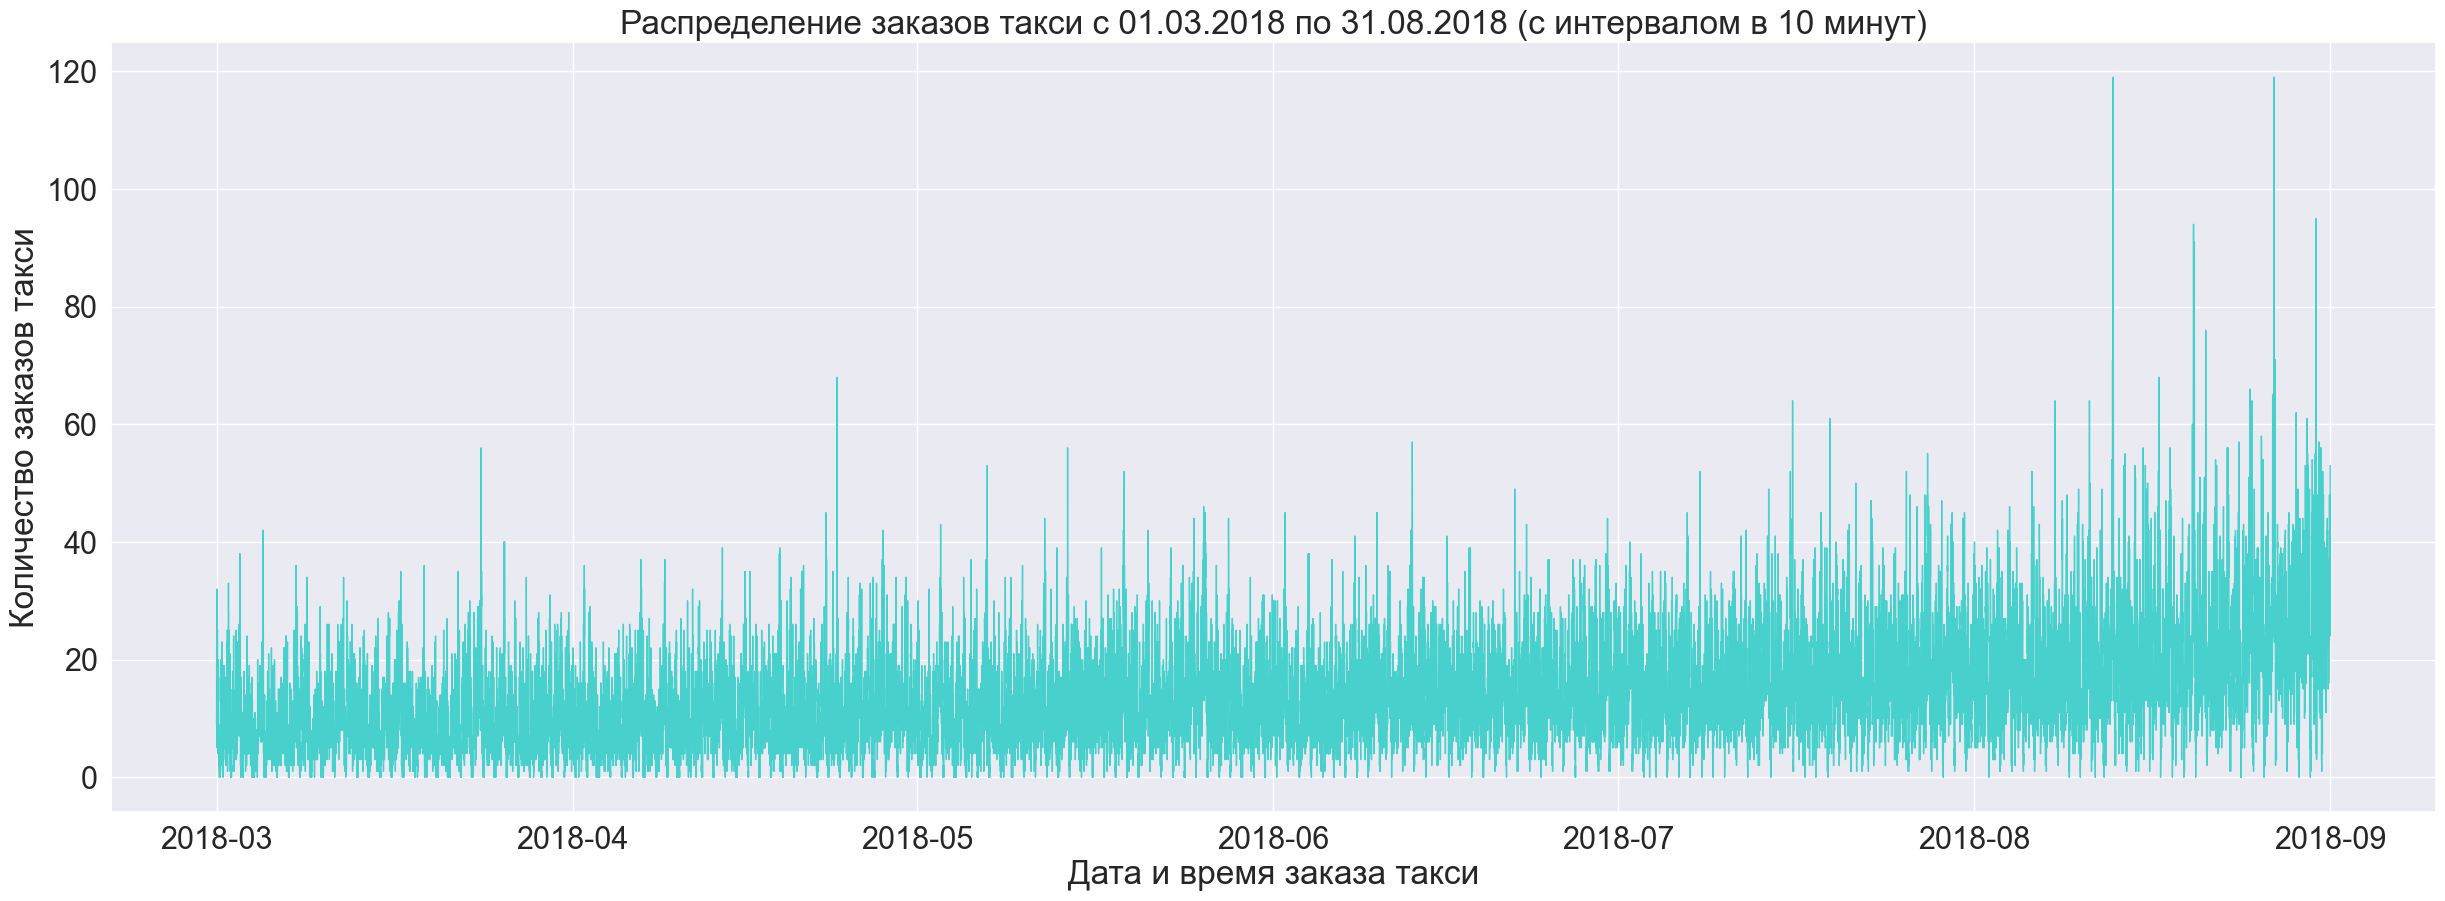

In [9]:
sns.set(font_scale= 2)
fig, ax = plt.subplots(figsize=(30,10))
plt.title('Распределение заказов такси с 01.03.2018 по 31.08.2018 (с интервалом в 10 минут)')
ax.set(xlabel='Дата и время заказа такси', ylabel='Количество заказов такси')
ax.plot(data.index, data, linewidth=1, color='mediumturquoise')
plt.show()

Видим, что в целом тенденция положительная - количество заказов постепенно растет на протяжении анализируемого периода. Однако анализировать данные достаточно сложно с таким коротким интервалом (10 минут). 

Проведем ресемплинг времени заказа такси с интервалом в 1 час.

In [10]:
data_resample = data.resample('1H').sum()
data_resample.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Посмотрим график еще раз.

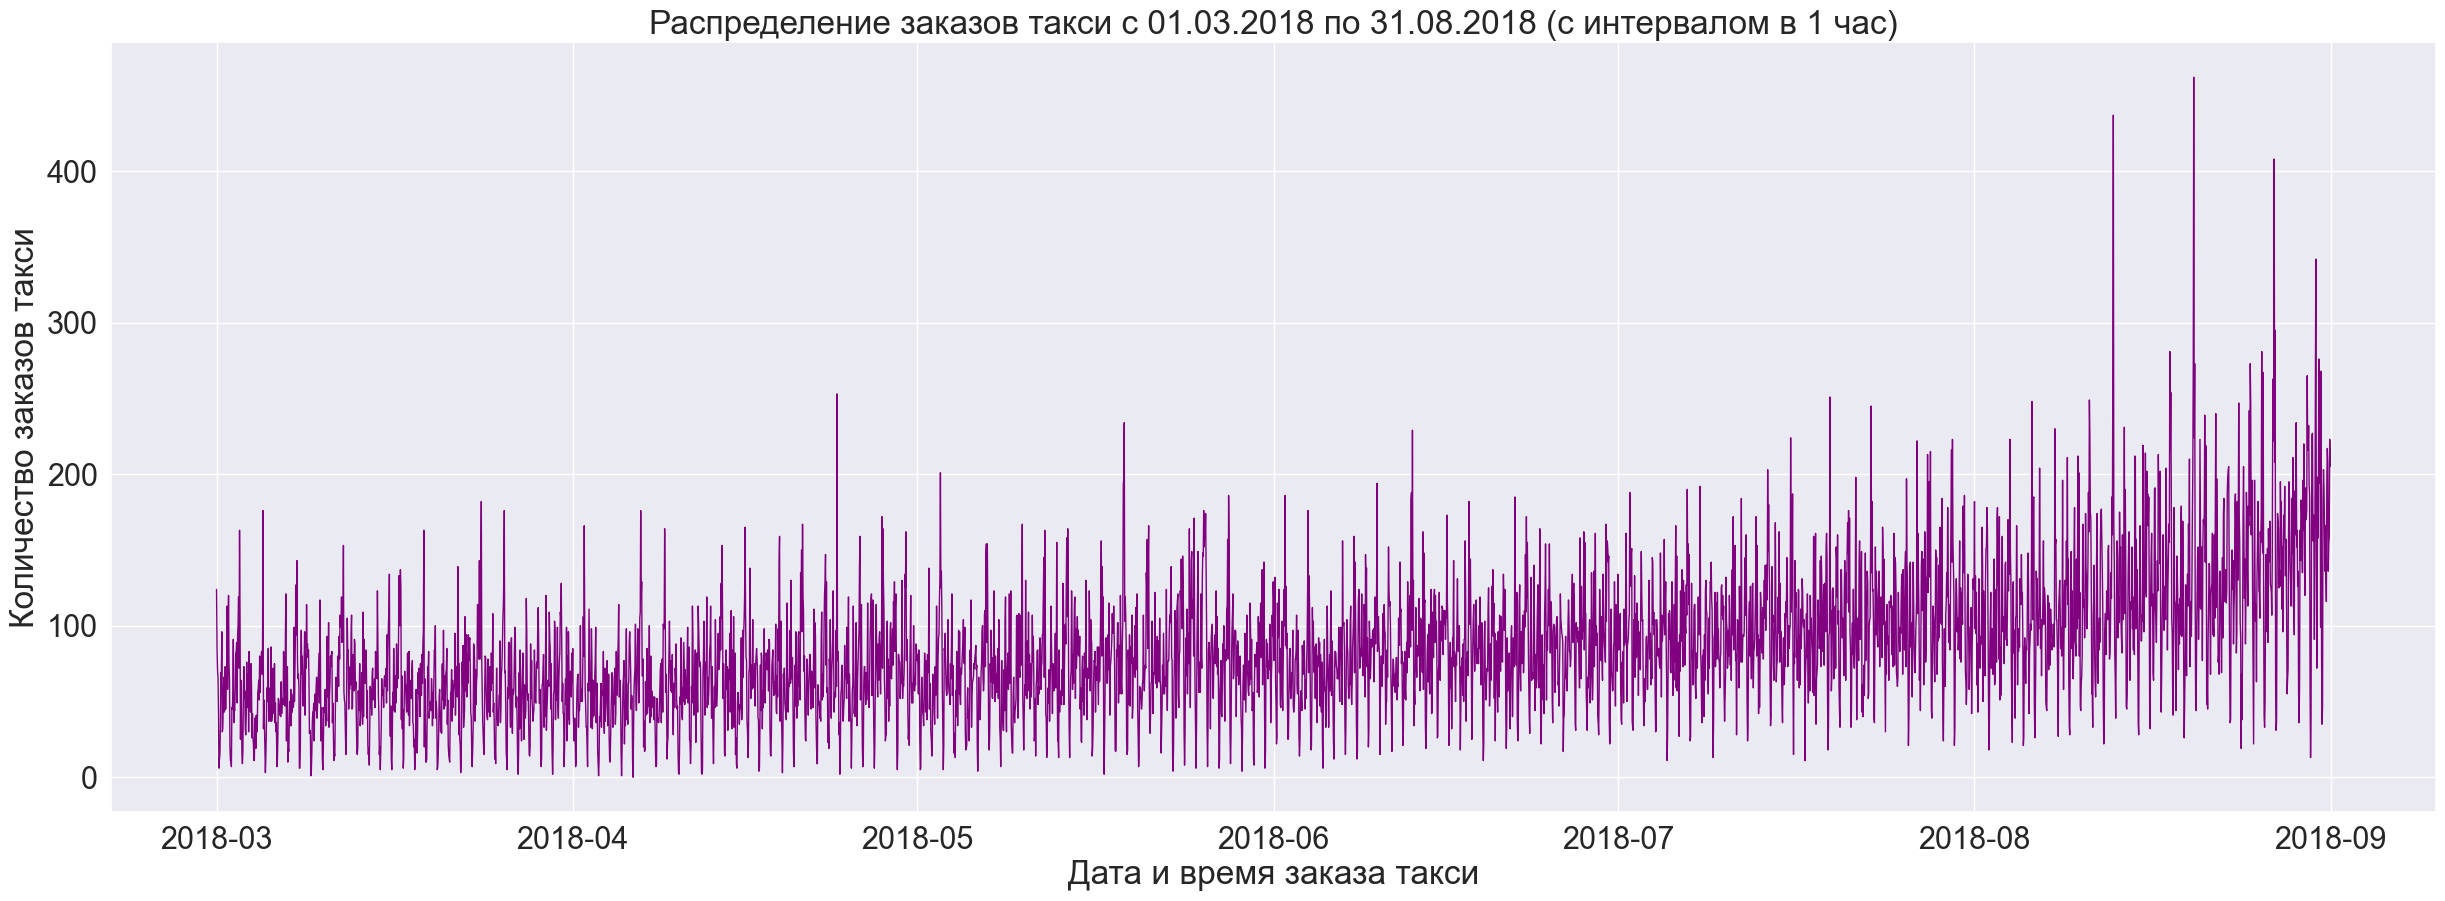

In [11]:
sns.set(font_scale= 2)
fig, ax = plt.subplots(figsize=(30,10))
plt.title('Распределение заказов такси с 01.03.2018 по 31.08.2018 (с интервалом в 1 час)')
ax.set(xlabel='Дата и время заказа такси', ylabel='Количество заказов такси')
ax.plot(data_resample.index, data_resample, linewidth=1, color='purple')
plt.show()

На графике практически не видно изменений. Проведем дальнейший анализ.

Перед началом аналитической части проверим наш временной ряд на стационарность. Для этого проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Воспользуемся модулем statsmodels, функцией adfuller():

In [12]:
result = adfuller(data_resample)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0]> result[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')    

ADF Statistic: -3.068924
p-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
единичных корней нет, ряд стационарен


**Выводы по результатам подготовки данных к анализу:**
1. При оценке общей информации о данных не обнаружено пропусков и дубликатов.
2. Проведены следующие этапы подготовки данных:
    - дата преобразована в необходимый формат и присвоена в качестве индекса;
    - временной ряд отсортирован, ресемплирован по одному часу и проверен на стационарность (проведен обобщенный тест Дикки-Фуллера на наличие единичных корней).

## Исследовательский анализ данных

Посмотрим диаграмму размаха по количеству заказов.

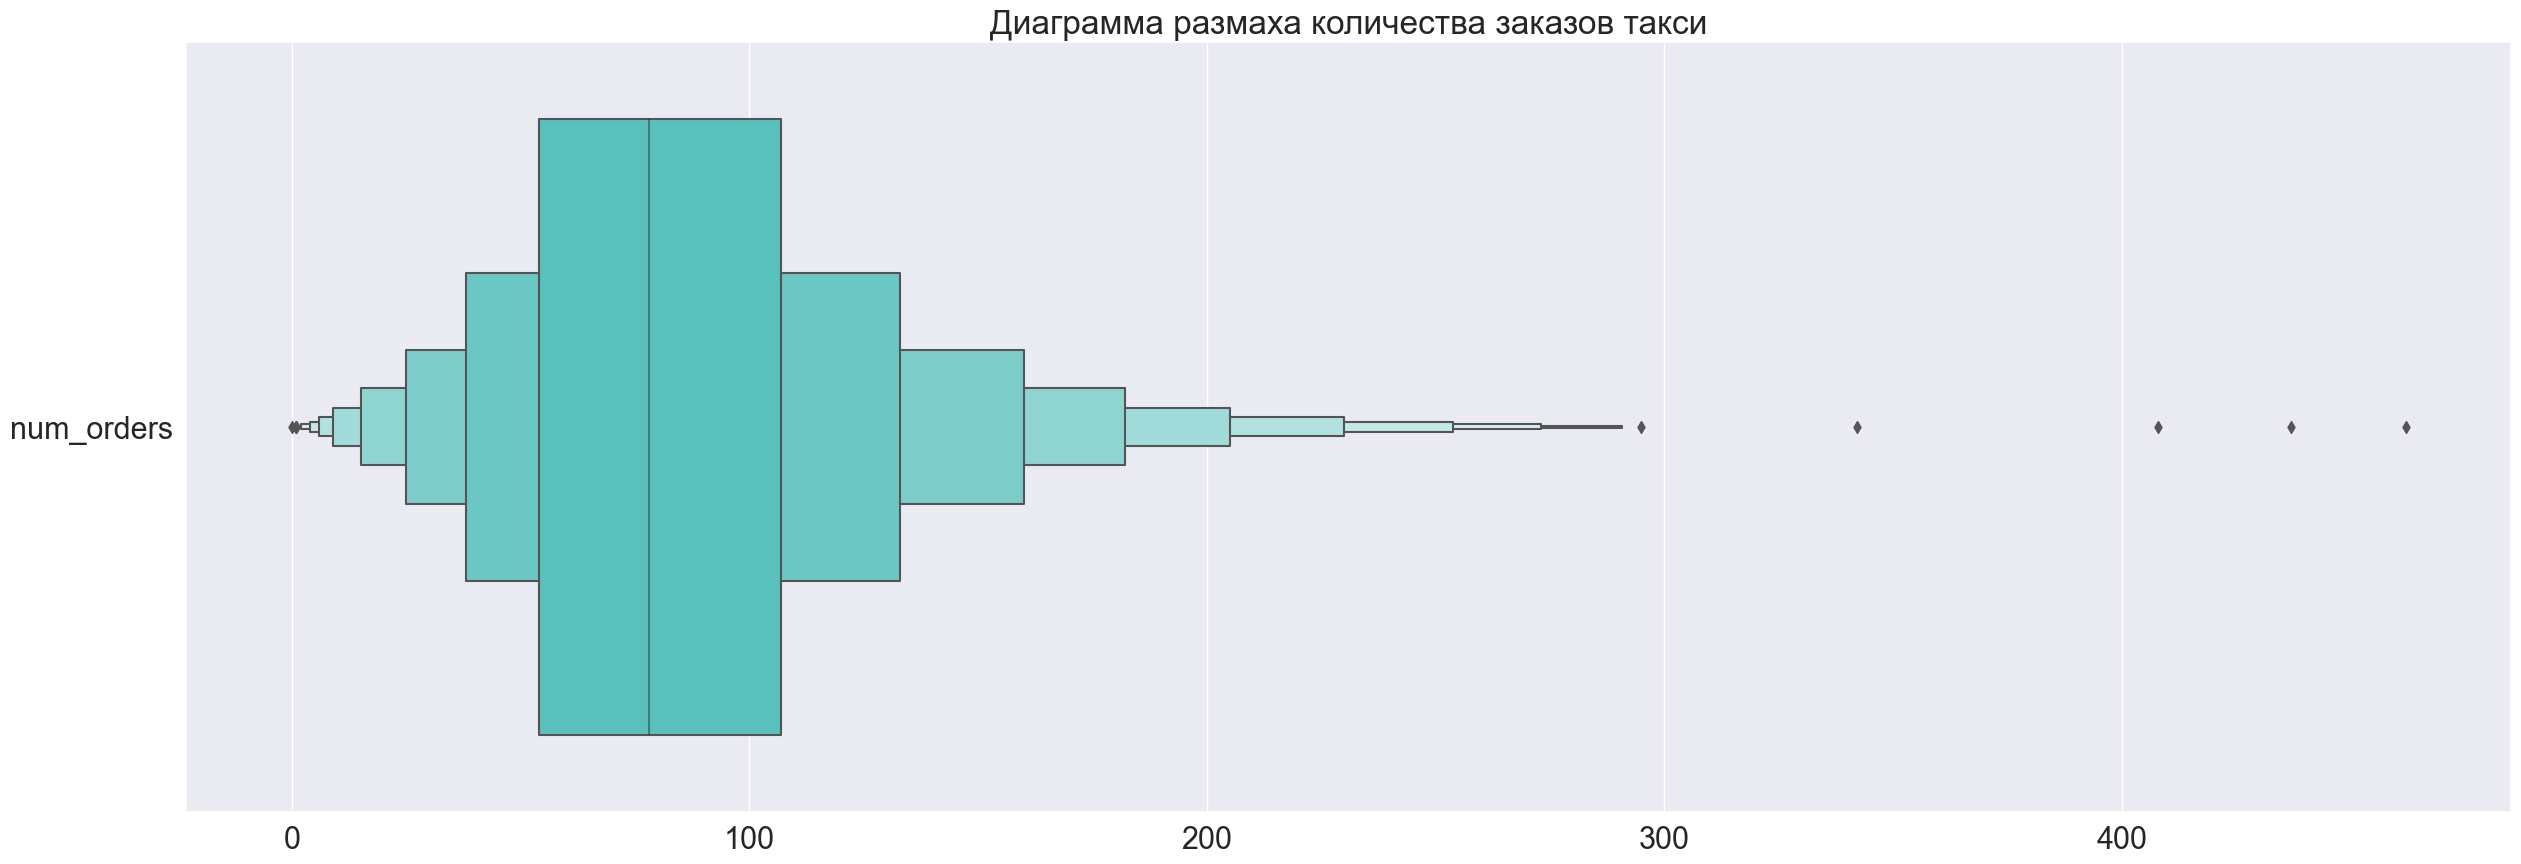

In [13]:
fig, ax = plt.subplots(figsize = (30,10))
ax = sns.boxenplot(data=data_resample, orient='h', color='mediumturquoise')
ax.set_title('Диаграмма размаха количества заказов такси')
plt.show()

При анализе боксплота видим, что есть интервалы с большим количеством заказов (свыше 300). Все они приходятся на вторую половину августа.

Посмотрим тренды и сезонность.

In [14]:
decomposed = seasonal_decompose(data_resample) 

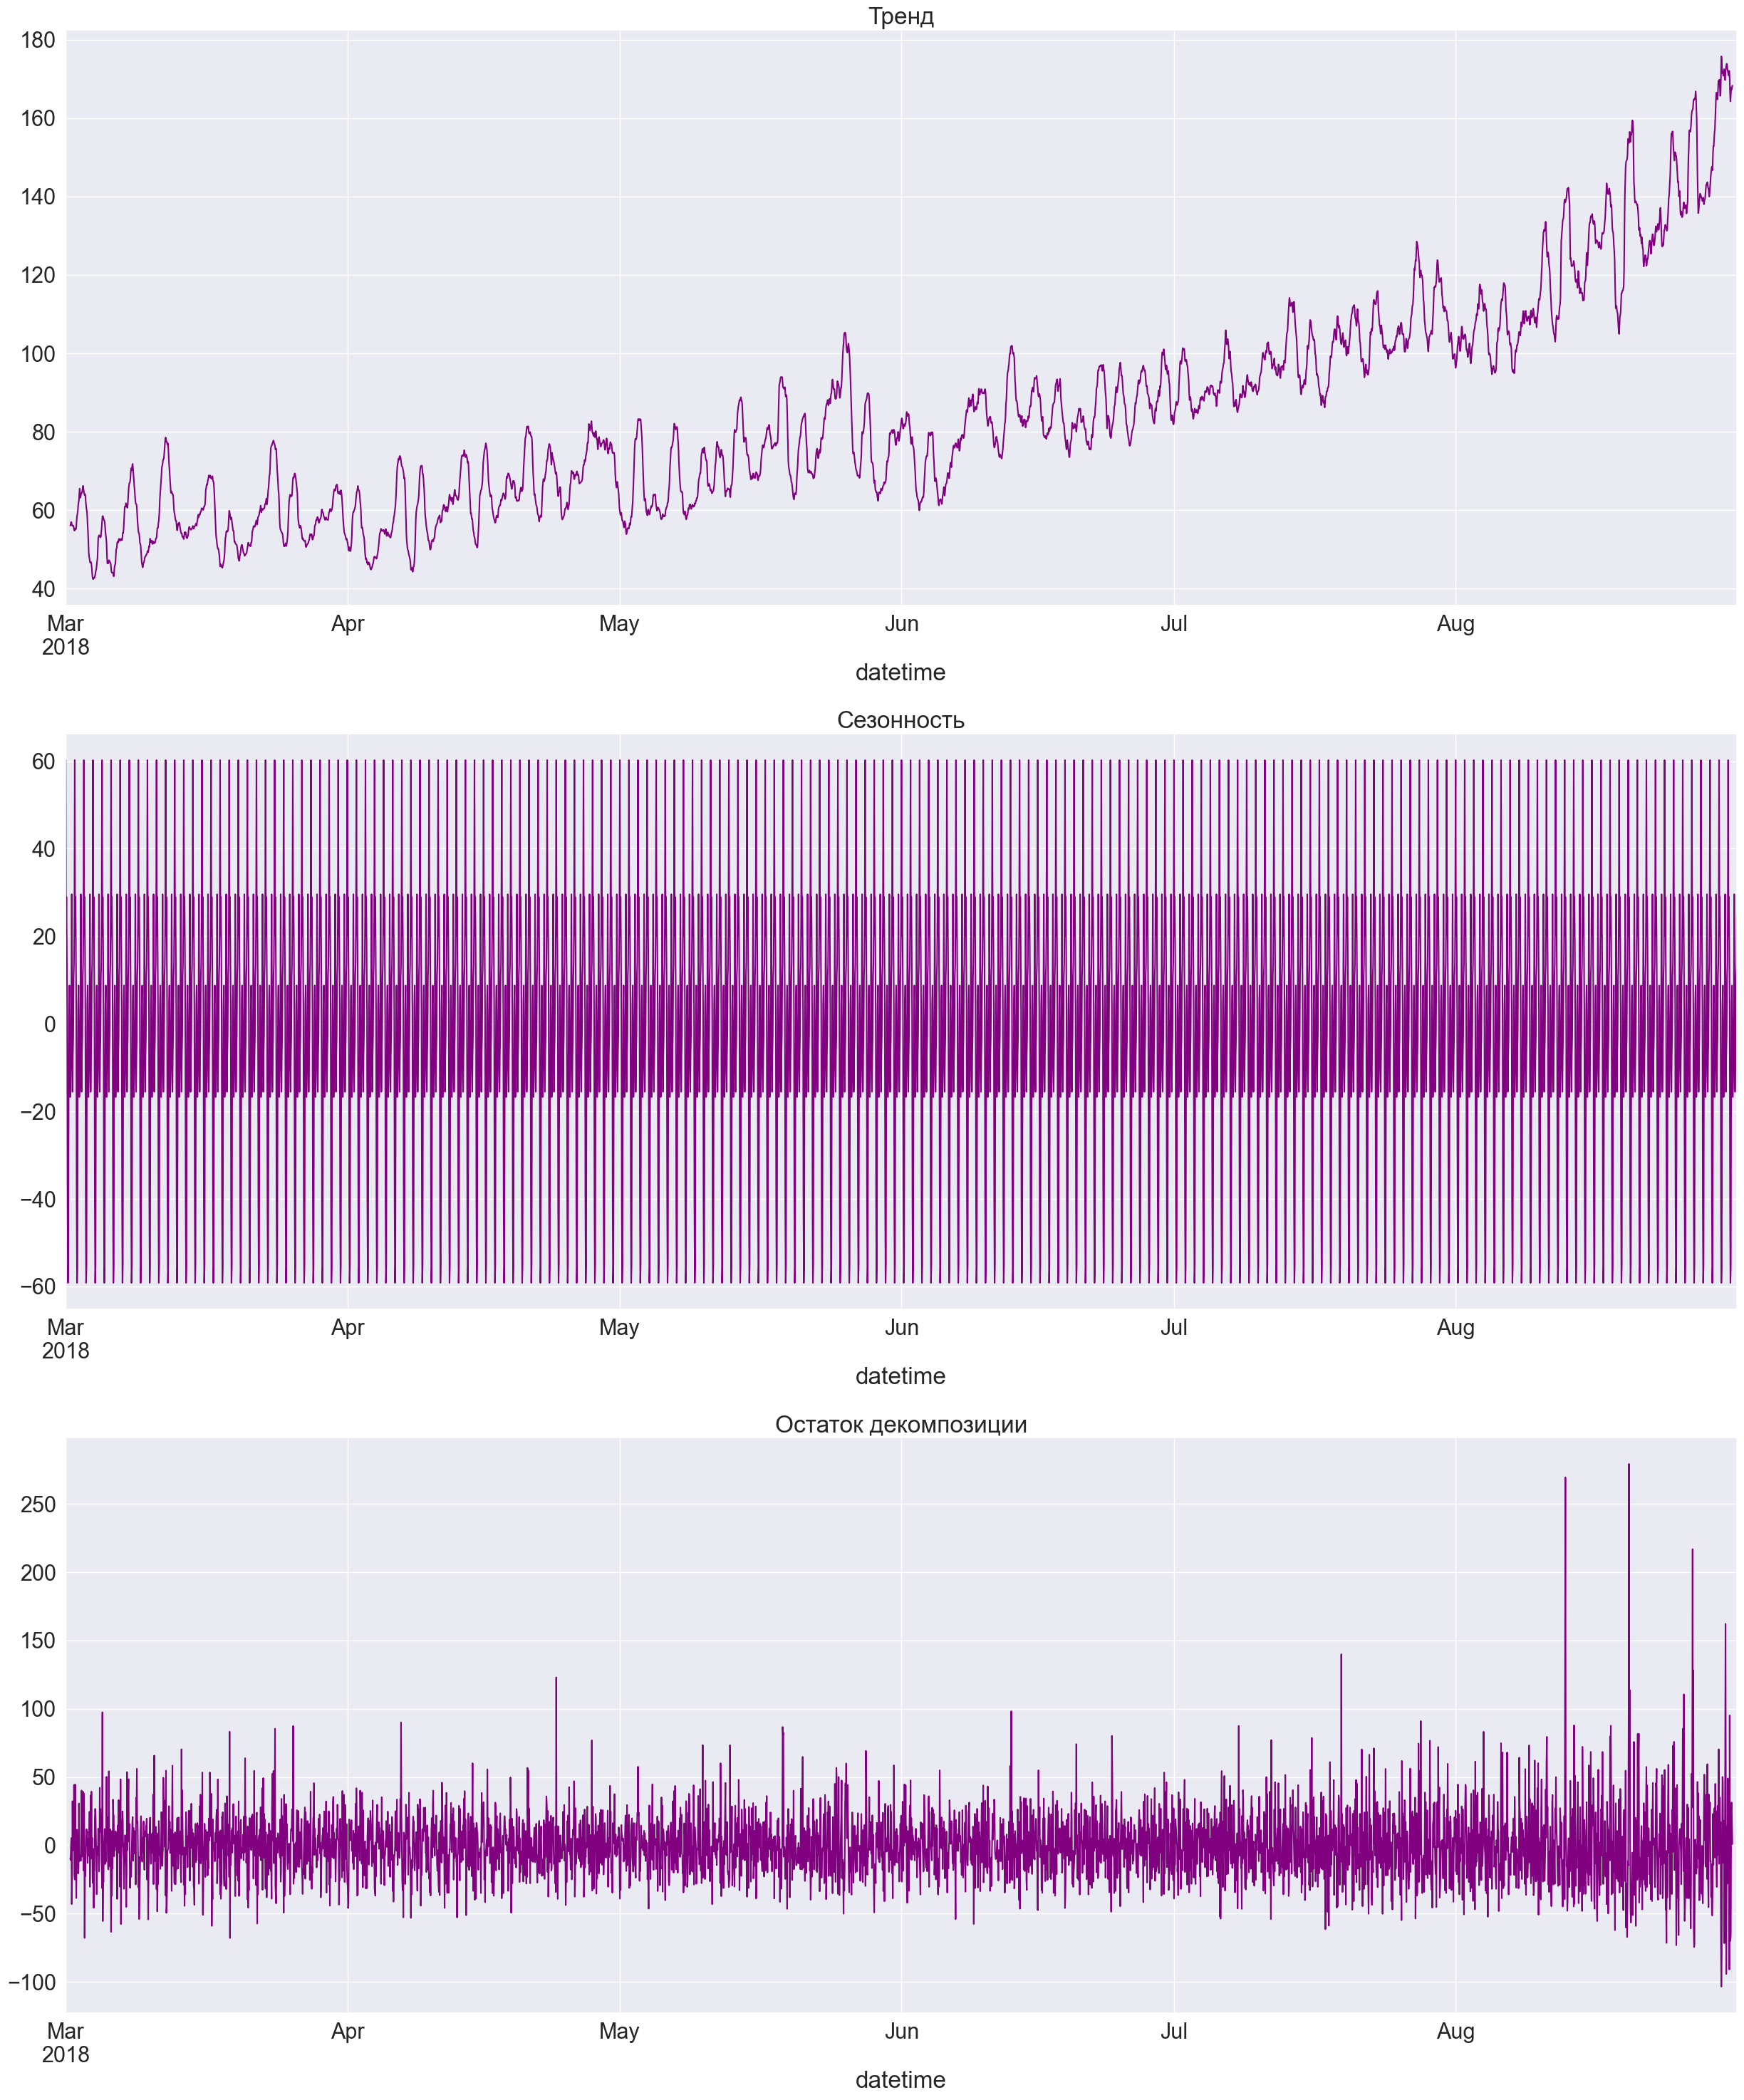

In [15]:
fig, ax = plt.subplots(figsize=(25,30))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), color='purple')
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='purple')
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='purple')
plt.title('Остаток декомпозиции')
plt.tight_layout()

На графике тренда видим тенденцию к росту заказов в течение всего анализируемого периода, особенно в последние месяцы (июль, август 2018г.). 
Также можно увидеть, что периодически происходят всплески в сторону увеличения и уменьшения заказов. Это подтверждается графиком сезонности, но чтобы ее оценить необходимо рассмотреть меньший период.

Построим график сезонной составляющей за несколько последних дней августа 2018 года.

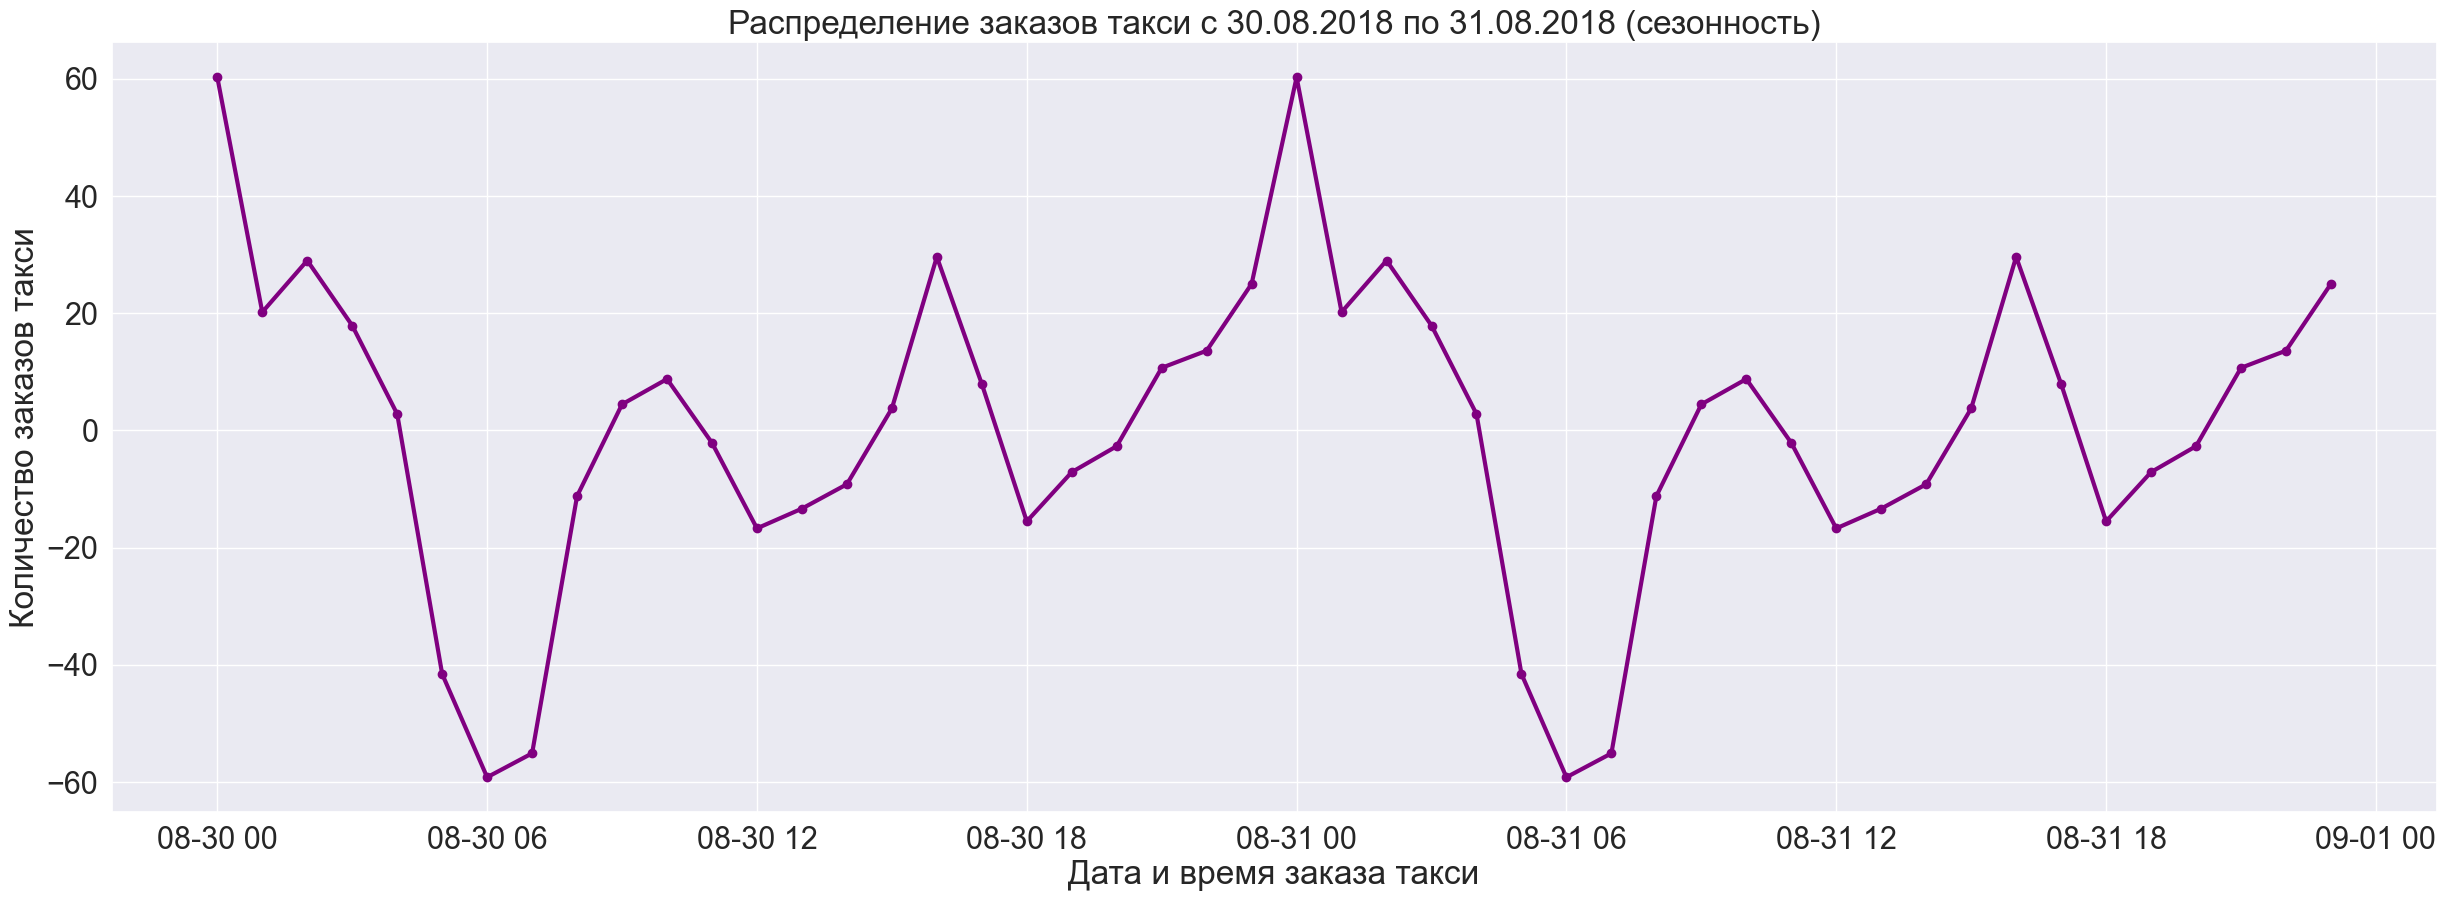

In [16]:
fig, ax = plt.subplots(figsize=(30,10))
plt.title('Распределение заказов такси с 30.08.2018 по 31.08.2018 (сезонность)')
ax.set(xlabel='Дата и время заказа такси', ylabel='Количество заказов такси')
ax.plot(decomposed.seasonal['2018-08-30':'2018-08-31'].index, decomposed.seasonal['2018-08-30':'2018-08-31'], 
        linewidth=3, color='purple', marker='o')
plt.show()

Теперь отчетливо видим, что рост заказов приходятся на 9-10 часов утра, 4 часа дня и максимальный пик - 12 часов ночи, а спад заказов наблюдается в 6-7 часов утра. 

**Выводы по исследовательскому анализу данных:**
1. В ходе исследовательского анализа данных оценена сезонность и тренды:
    - выявлена тенденция к росту заказов в течение всего анализируемого периода, особенно в последние месяцы (июль, август 2018г.);
    - сезонность отмечена суточная (цикличность спроса на такси в течение 24 часов).
2. Определено время суток с максимальной нагрузкой водителей (максимальное количество заказов) - 12 часов ночи. Рост заказов наблюдается также в период 9-10 часов утра и 4-х часов дня.

## Обучение моделей

### Функции для оптимизации работы с обучением моделей

In [17]:
def rmse(target, predict):
    mse = mean_squared_error(target, predict)
    return mse**0.5
rmse_score = make_scorer(rmse, greater_is_better=False)

In [18]:
# создадим функции для подбора параметров
# целевой метрикой качества выберем rmse_score
def gridsearch (model, params, features_train, target_train):
    '''подбирает гиперпараметры к модели с помощью GridSearchCV'''
    time_cv = TimeSeriesSplit(n_splits = 5)
    grid = GridSearchCV(model, params, n_jobs=-1, scoring=rmse_score, cv=time_cv, verbose = False)
    grid.fit(features_train, target_train)
    print('Лучшие параметры модели:', grid.best_params_)
    print(f'{model}','RMSE: {:.2f}'.format(grid.best_score_))
    return grid

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    '''создает дополнительные признаки для временного ряда'''
    data_features = data.copy()
    data_features['dayofweek'] = data_features.index.dayofweek
    data_features['hour'] = data_features.index.hour
    for lag in range(1, max_lag + 1):
        data_features['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data_features['rolling_mean'] = data_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_features

### Создание признаков

Перед тем как определять максимальный лаг для создания признаков, посмотрим на результаты автокорреляционной функции.

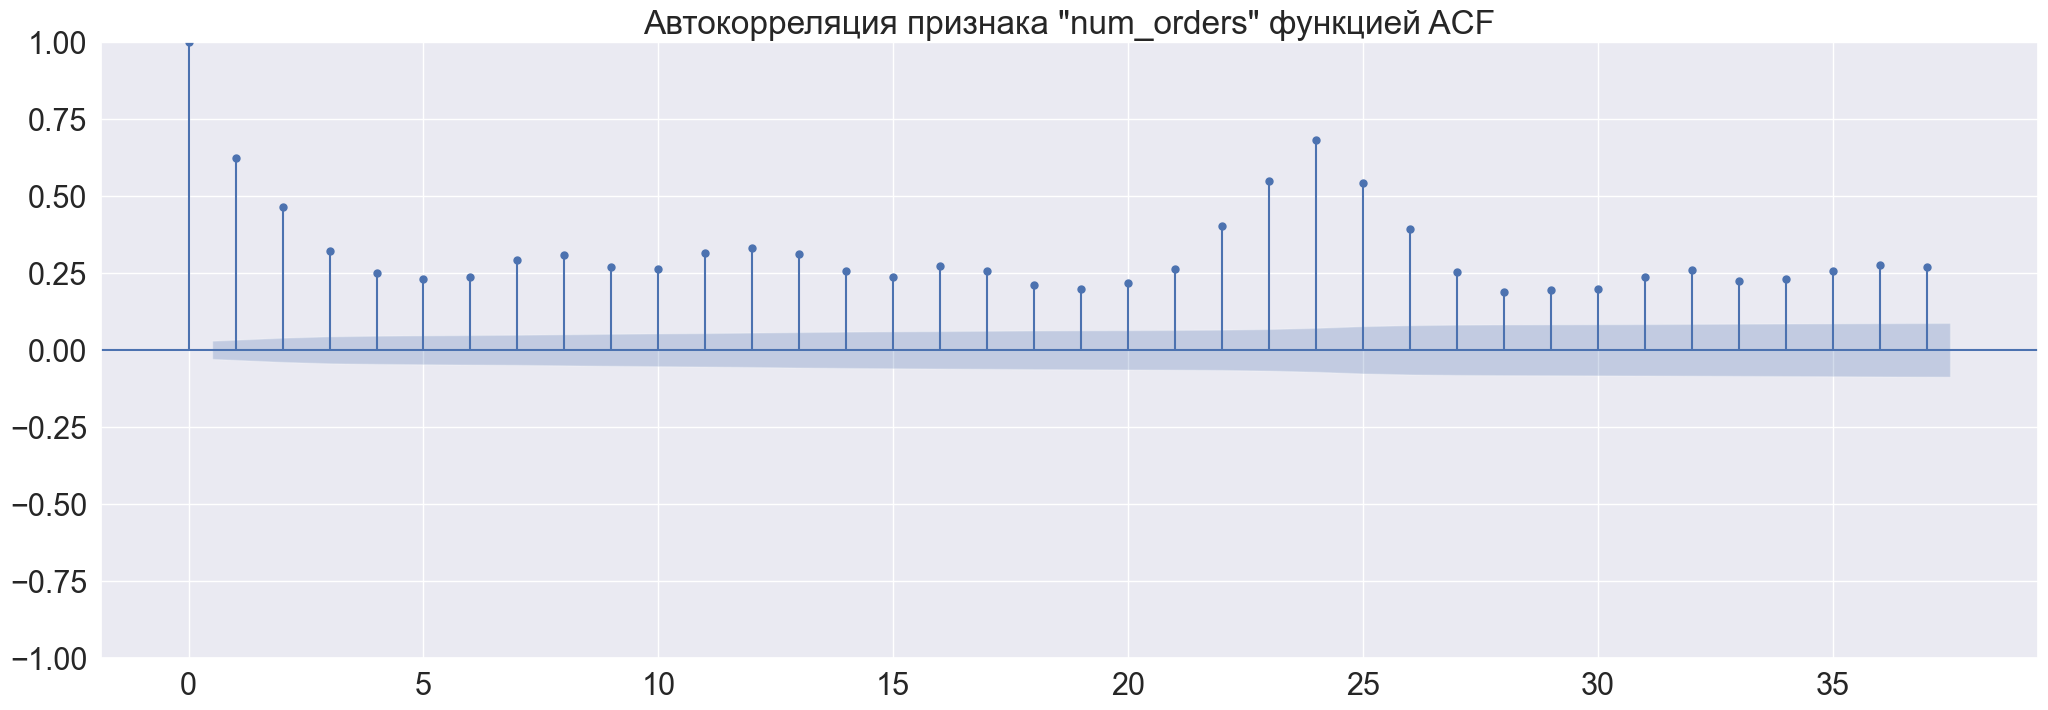

In [20]:
# построим график автокорреляционной функции (ACF)  
plt.rc("figure", figsize=(25,8))
plot_acf(data_resample)
plt.title('Автокорреляция признака "num_orders" функцией ACF')
plt.show()

Из графика видим, что самая большая корреляция с целевым признаком наблюдается при максимальном лаге 24, что не удивительно, так как сезонность была выявлена именно посуточно. Возьмем это значение для создания признаков.

In [21]:
# создаем дополнительные признаки
data_features = make_features(data_resample, 24, 5)

In [22]:
data_features.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Деление данных на выборки 

In [23]:
train, test = train_test_split(data_features, shuffle=False, test_size=0.1)
train = train.dropna()

Данные разделены корректно.

Отделяем целевой признак от прочих.

In [24]:
features_train = train.drop('num_orders', axis=1) 
target_train = train['num_orders'] 
features_test = test.drop('num_orders', axis=1) 
target_test = test['num_orders'] 

In [25]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((3950, 27), (3950,), (442, 27), (442,))

Посмотрим на разделение на графике.


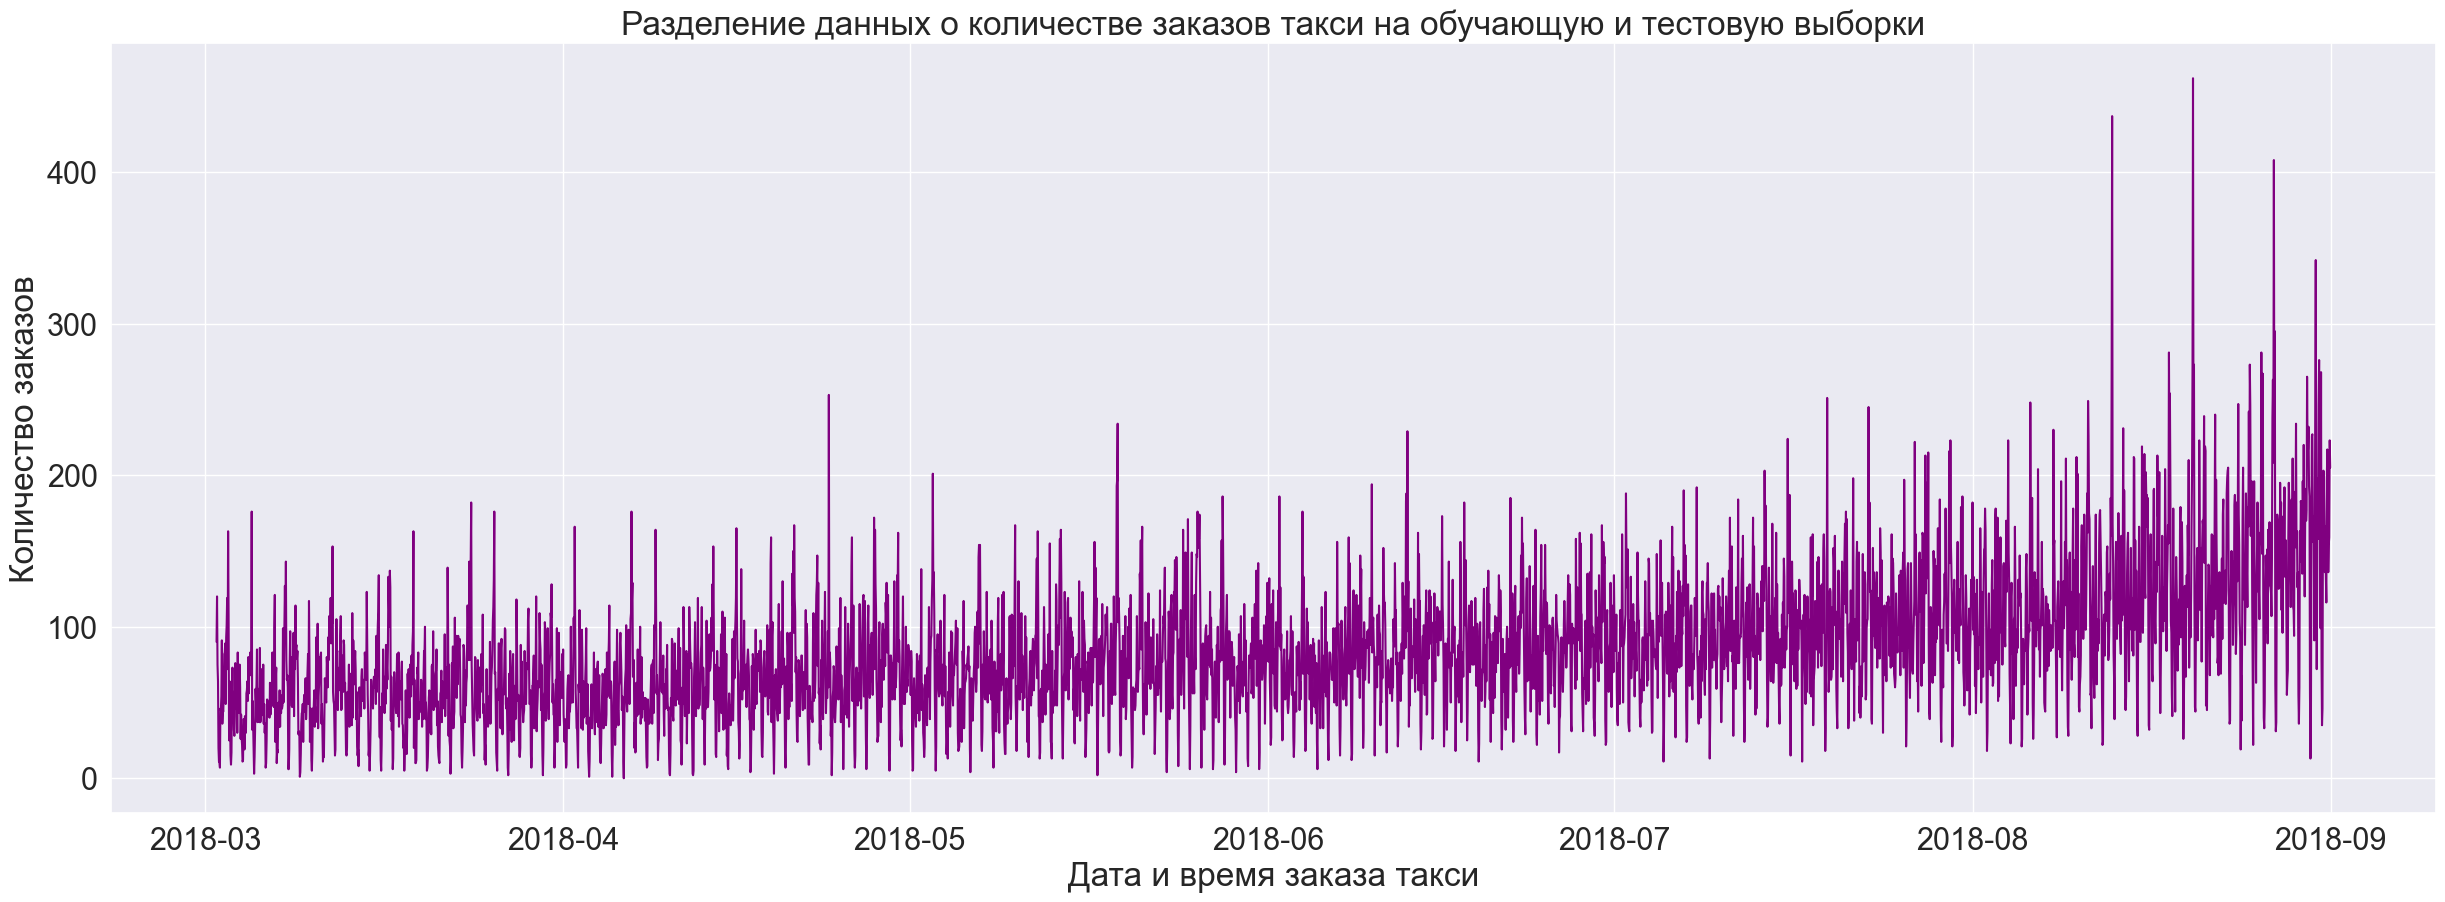

In [26]:
fig, ax = plt.subplots(figsize=(30,10))
plt.plot(target_train, color = "purple")
plt.plot(target_test, color = 'purple')
plt.title('Разделение данных о количестве заказов такси на обучающую и тестовую выборки')
plt.ylabel('Количество заказов')
plt.xlabel('Дата и время заказа такси')
plt.show()

Приступаем к подбору гиперпараметров моделей.

### Подбор гиперпараметров для моделей

In [27]:
cb_params = {'iterations': [1000],
            'learning_rate': [0.03, 0.1],
            'depth': [6, 8],
            'l2_leaf_reg': [1, 3],
            'logging_level': ['Silent'],
            'loss_function':['RMSE']}

lgbm_params = {'n_estimators':[100, 200, 400, 700, 1000],
               'learning_rate': [0.1, 0.25, 0.5],
               'max_depth': [5, 10, 15, 20],
              'objective': ['root_mean_squared_error']}

tree_params = {'max_depth': [10,15,20],
              'min_samples_leaf':range (2,11,2),
              'min_samples_split':range(2,11,2)}

forest_params = {'n_estimators': [10,20,30],
                   'max_depth':[5,15],
                   'min_samples_leaf':[2, 4, 8, 10],
                   'min_samples_split':[2, 4, 8, 10]}

Перед тем, как мы начнем обучение моделей, создадим константную модель (dummy), которая предсказывает среднее значение. Это позволит проводить сравнительную оценку метрик качества моделей.

In [28]:
# создаем и обучаем модель со средним значением целевого признака
dummy_clf = DummyRegressor(strategy='mean')
dummy_clf.fit(features_train, target_train)
predictions_test = dummy_clf.predict(features_test)
rmse_dummy = rmse(target_test, predictions_test)
print("RMSE на тестовой выборке: %.2f" % rmse_dummy)

RMSE на тестовой выборке: 84.65


#### CatBoostRegressor

In [29]:
%%time
cb_grid = gridsearch(CatBoostRegressor(random_state=SEED), cb_params, features_train, target_train)

Лучшие параметры модели: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.03, 'logging_level': 'Silent', 'loss_function': 'RMSE'}
<catboost.core.CatBoostRegressor object at 0x000001802BFBEFD0> RMSE: -24.04
CPU times: total: 25.4 s
Wall time: 6min 10s


Для экономии времени загрузки модели с лучшими параметрами, сохраним параметры и полученную модель в переменные.

In [30]:
cb_grid = CatBoostRegressor(random_state=SEED, depth=6, iterations = 1000, l2_leaf_reg=1, learning_rate=0.03, 
                            logging_level='Silent', loss_function='RMSE')

#### LGBMRegressor

In [31]:
%%time
lgbm_grid = gridsearch(LGBMRegressor(random_state=SEED), lgbm_params, features_train, target_train)

Лучшие параметры модели: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'objective': 'root_mean_squared_error'}
LGBMRegressor(random_state=12345) RMSE: -24.66
CPU times: total: 2.22 s
Wall time: 2min 14s


Для экономии времени загрузки модели с лучшими параметрами, сохраним параметры и полученную модель в переменные.

In [32]:
lgbm_grid = LGBMRegressor(random_state=SEED, max_depth = 5, n_estimators = 100, learning_rate = 0.1, 
                          objective ='root_mean_squared_error')

#### RandomForestRegressor

In [33]:
%%time
forest_grid = gridsearch(RandomForestRegressor(random_state=SEED), forest_params, features_train, target_train)

Лучшие параметры модели: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 30}
RandomForestRegressor(random_state=12345) RMSE: -25.59
CPU times: total: 4.16 s
Wall time: 1min 16s


Для экономии времени загрузки модели с лучшими параметрами, сохраним параметры и полученную модель в переменные.

In [34]:
forest_grid = RandomForestRegressor(random_state=SEED, max_depth=15, n_estimators=30, min_samples_leaf=2, min_samples_split=2)

#### DecisionTreeRegressor и BaggingRegressor

In [35]:
%%time
tree_grid = gridsearch(DecisionTreeRegressor(random_state=SEED), tree_params, features_train, target_train)

Лучшие параметры модели: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
DecisionTreeRegressor(random_state=12345) RMSE: -29.59
CPU times: total: 672 ms
Wall time: 6.67 s


Для экономии времени загрузки модели с лучшими параметрами, сохраним параметры и полученную модель в переменные.

In [36]:
tree_grid = DecisionTreeRegressor(random_state=SEED, max_depth=10, min_samples_leaf=10, min_samples_split=2)

In [37]:
bagging_tree = BaggingRegressor(tree_grid, n_estimators=1000, random_state=SEED)

### Оценка моделей с помощью кросс-валидации

Проверим модели с помощью кросс-валидации и посчитаем средний результат rmse.

In [38]:
%%time
grid_models = {}
grid_models['CatBoost'] = cb_grid
grid_models['LGBM'] = lgbm_grid
grid_models['Forest'] = forest_grid
grid_models['Bagging_tree'] = bagging_tree

tscv = TimeSeriesSplit(n_splits=7)
print(tscv)

results_rmse = []
results_rmse_mean = []
print('RMSE')

for key in grid_models:
    cv_result = cross_val_score(grid_models[key], features_train, target_train, cv=tscv, scoring = rmse_score)
    results_rmse.append(cv_result)
    results_rmse_mean.append(round(cv_result.mean(),2))
    print('%s: %f (%f)' % (key, cv_result.mean(), cv_result.std()))

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=None)
RMSE
CatBoost: -23.849384 (3.225664)
LGBM: -24.535853 (3.236816)
Forest: -25.195186 (3.745239)
Bagging_tree: -25.174439 (3.954809)
CPU times: total: 4min 3s
Wall time: 2min 39s


Визуализируем полученные результаты.

In [47]:
def graf_model(results, models, name):
    '''строит боксплоты по результатам обучения моделей с метрикой RMSE'''
    fig = plt.figure(figsize=(25, 5))
    fig.suptitle(f'Результаты обученных моделей по прогнозированию {name}')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(models.keys())
    plt.show()

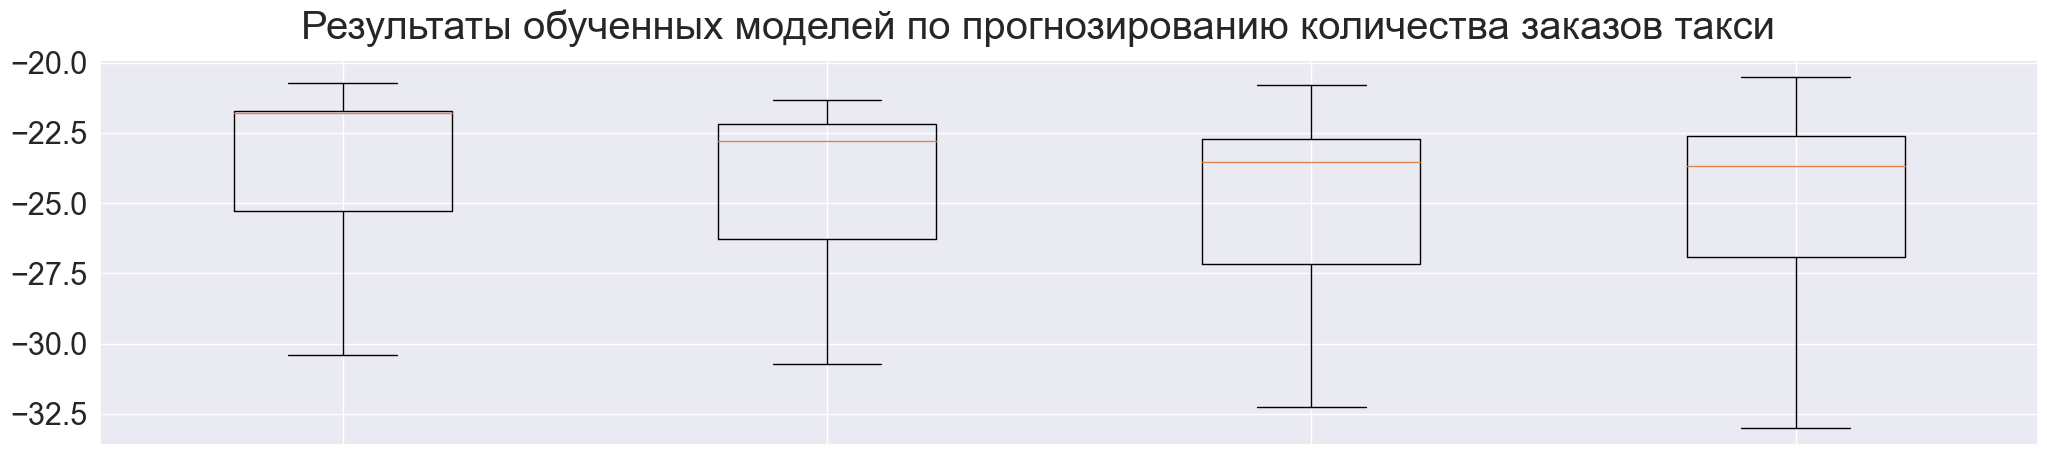

In [48]:
graf_model(results_rmse, grid_models, 'количества заказов такси')

Результаты проверки в табличной форме.

In [41]:
models_simile = pd.DataFrame(results_rmse_mean, 
                                   columns=['Средний RMSE по итогам кросс-валидации'], 
                                   index=['CatBoost','LGBM','RandomForest', 'BaggingTree'])
models_simile

,Средний RMSE по итогам кросс-валидации
CatBoost,-23.85
LGBM,-24.54
RandomForest,-25.20
BaggingTree,-25.17


По итогам проверки моделей с помощью кросс-валидации модель CatBoostRegressor показала самый низкий RMSE из всех обученных моделей, в частности, медиана результатов данной модели стремится к минимуму. Протестируем модель на тестовой выборке.

## Тестирование выбранной модели

In [42]:
start_time = time.time()
y_pred_test = cb_grid.fit(features_train, target_train).predict(features_test)
time_fit_pred = round((time.time() - start_time),2)
print('RMSE на тестовой выборке:', round(rmse(target_test, y_pred_test),2))
print('Общее время обучения и предсказания:', time_fit_pred, 'секунд')

RMSE на тестовой выборке: 39.43
Общее время обучения и предсказания: 7.87 секунд


In [43]:
y_pred_test = pd.Series(y_pred_test, index=target_test.index)

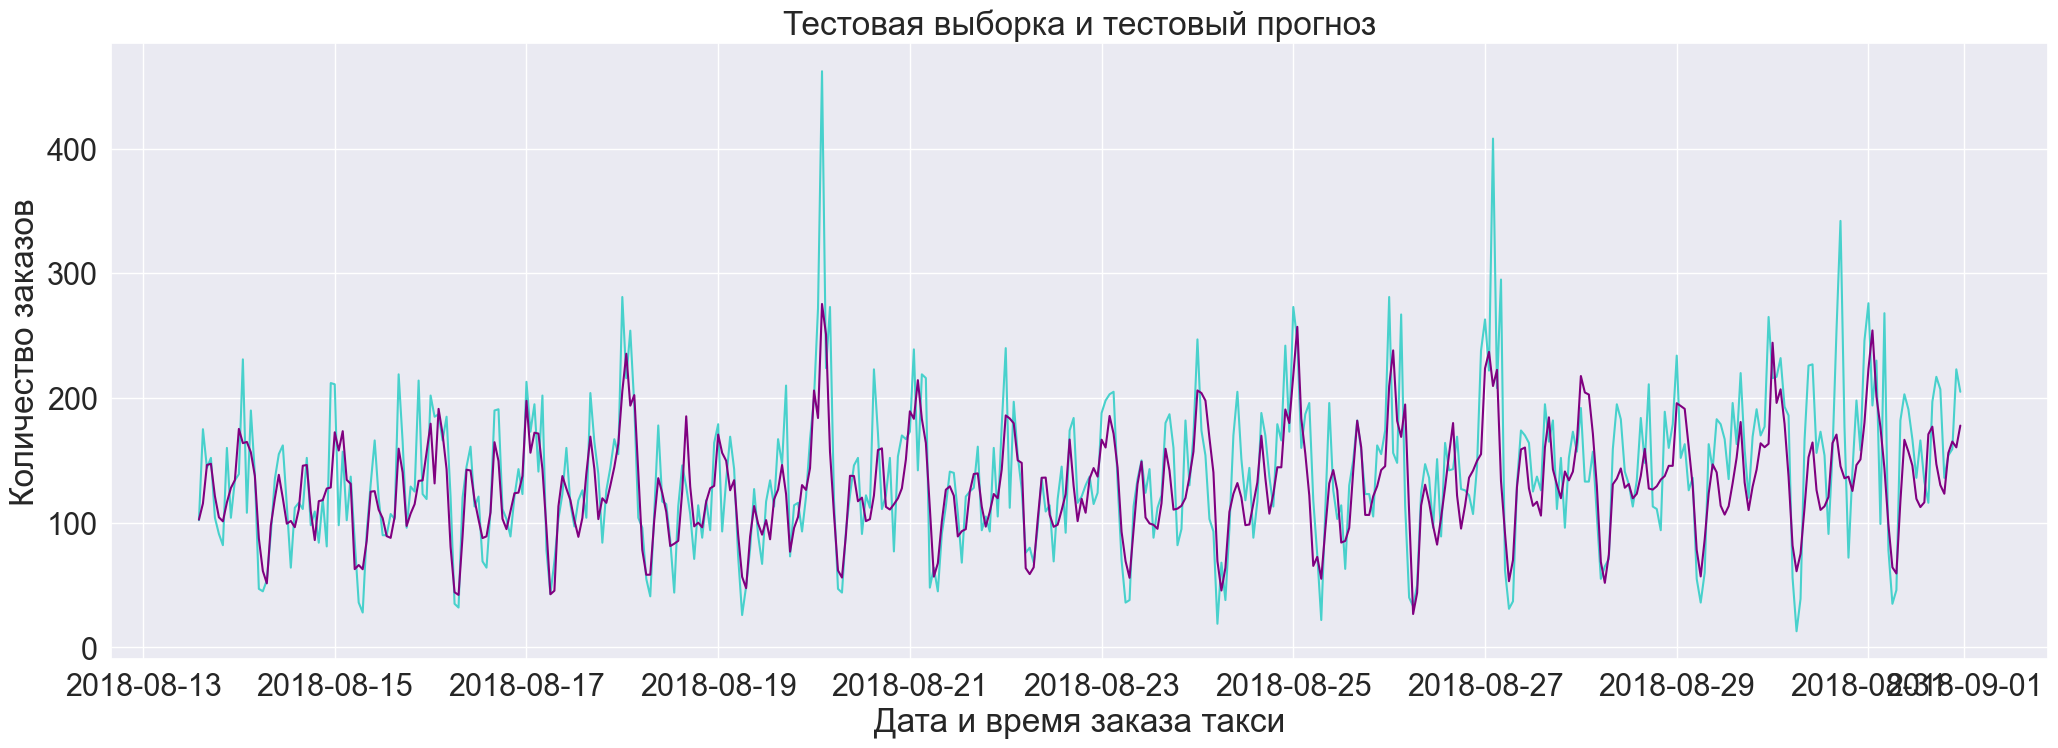

In [44]:
# отразим на графике тестовую выборку и тестовый прогноз
plt.plot(target_test, color = "mediumturquoise")
plt.plot(y_pred_test, color = "purple")
plt.title("Тестовая выборка и тестовый прогноз")
plt.ylabel('Количество заказов')
plt.xlabel('Дата и время заказа такси')
plt.show()

Полученные результаты тестирования модели удовлетворяют поставленным целям проекта - RMSE на тестовой выборке ниже 48.

Обученная модель показывает RMSE (39.43) в 2 раза меньше, чем dummy модель (84.65).

## Выводы по результатам проекта

**В ходе проекта были выполнены следующие этапы:**

- Проведена предобработка данных и подготовка их к построению модели.


- В ходе исследовательского анализа данных оценена сезонность и тренды:
    - выявлена тенденция к росту заказов в течение всего анализируемого периода, особенно в последние месяцы (июль, август 2018г.);
    - сезонность отмечена суточная (цикличность спроса на такси в течении 24 часов).
    
  Определено время суток с максимальной нагрузкой водителей (максимальное количество заказов) - 12 часов ночи. Рост заказов наблюдается также в период 9-10 часов утра и 4-х часов дня.
  
  
- Проведен подбор гиперпараметров c помощью GridSearchCV.


- Обучены и оценены результаты следующих моделей: 

In [45]:
models_simile

,Средний RMSE по итогам кросс-валидации
CatBoost,-23.85
LGBM,-24.54
RandomForest,-25.20
BaggingTree,-25.17


Модель CatBoostRegressor с лучшими результатами по RMSE выбрана для тестирования.

В ходе тестирования получены следующие результаты:

- RMSE на тестовой выборке: 39.43
- Результаты предсказания модели сравнили с моделью dummy, которая показала итоговый RMSE в 2 раза больше (84.65).